# **Practice Lab: Implementing Q-Learning in Reinforcement Learning**

## **Objective**

In this practice lab, you will implement a Q-learning algorithm to solve a reinforcement learning problem. Specifically, you will work with the FrozenLake environment provided by OpenAI Gym. The goal is to train an agent to navigate through a grid world and reach the goal while avoiding holes.

<img align="Right" src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*LtzJxmqN0jRcF0ljTlr6QQ.png" width = 40% >

## **Background**

Q-learning is a model-free reinforcement learning algorithm used to find the optimal action-selection policy for a given finite Markov decision process (MDP). The Q-learning algorithm updates the Q-values based on the Bellman equation:

$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]$

where:


*   $Q(s,a)$ is the Q-value for state $s$ and action $a$.
*   $\alpha$ is the learning rate.
*   $r$ is the reward received after taking action $a$ in state $s$.
*   $\gamma$ is the discount factor.
*   $\max_{a'} Q(s', a')$ is the maximum Q-value for the next state s'.




## **FrozenLake Environment**

The FrozenLake environment is a grid world where the goal is to navigate from a starting position to a goal position while avoiding holes. The environment is a simple grid with states, actions, and rewards.

## **Implementation Steps**

### 1. Set Up Environment

First, we need to install and import the necessary libraries and set up the FrozenLake environment.

In [1]:
# Install required packages
!pip install gym==0.25.2

import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

### 2. Initialize Q-Table

The Q-table is a matrix where rows correspond to states and columns correspond to actions. We initialize it with zeros.

In [ ]:
# Initialize the FrozenLake environment with new_step_api=True
env = gym.make('FrozenLake-v1', render_mode='ansi', is_slippery=False, new_step_api=True)

# Print the size of the observation space (number of states)
print("Number of states:", env.observation_space.n)  # Should print 16

# Reset the environment and print the initial state
initial_state = env.reset()
print("Initial state:", initial_state)  # Should print 0

# Initialize the Q-table with zeros
n_actions = env.action_space.n  # Number of possible actions
n_states = env.observation_space.n  # Number of possible states
Q = np.zeros((n_states, n_actions))  # Create a Q-table of size [states x actions]

# Define Q-learning parameters
alpha = 0.1        # Learning rate: Slowly updates the action in the Q-table
gamma = 0.99       # Discount factor: Places high importance on states that bring the agent closer to the goal
epsilon = 1.0      # Initial exploration rate (starts with high exploration)
epsilon_decay = 0.995  # Rate at which epsilon decreases over episodes
max_epsilon = 1.0  # Maximum exploration rate
min_epsilon = 0.01  # Minimum exploration rate
n_episodes = 1000  # Total number of training episodes
max_steps = 100    # Maximum number of steps allowed per episode


Number of states: 16
Initial state: 0


### **1. `alpha` (Learning Rate)**

- **Definition**: Controls how much new information overrides old information in the Q-table.
- **Concrete Example**:
  - Suppose the agent has already learned that for state `S` and action `A`, the estimated reward is `Q(S, A) = 10`.
  - In a new episode, the agent discovers that taking `A` results in a reward of `8`.
    - With **`alpha = 0.1`**: The agent updates the value slowly, resulting in a new Q-value close to `10`.
    - With **`alpha = 0.9`**: The agent gives more importance to the new information and significantly adjusts the Q-value toward `8`.

---

### **2. `gamma` (Discount Factor)**

- **Definition**: Determines the importance of future rewards compared to immediate rewards.
- **Concrete Example**:
  - The agent is 3 steps away from a goal that yields a reward of `1`.
    - With **`gamma = 0.99`**: The agent assigns high value to states leading closer to the goal since it "looks far ahead."
    - With **`gamma = 0.1`**: The agent focuses only on immediate rewards, ignoring steps needed to reach the goal.

- In **Frozen Lake**, a high `gamma` is essential as the goal is often far away, requiring prioritization of paths leading to success.

---

### **3. `epsilon` (Exploration Rate)**

- **Definition**: Balances the exploration-exploitation trade-off. A high `epsilon` encourages exploration, while a low `epsilon` favors exploiting current knowledge.
- **Concrete Example**:
  - Suppose the agent is at the very beginning of training.
    - With **`epsilon = 1.0`**: The agent makes random decisions to explore the environment and avoid missing interesting paths.
    - With **`epsilon = 0.1`**: The agent mostly chooses the action with the highest estimated Q-value, risking getting stuck in suboptimal solutions.

---

### **4. `epsilon_decay`**

- **Definition**: Gradually reduces the exploration rate (`epsilon`) with each episode.
- **Concrete Example**:
  - Initially, the agent explores with **`epsilon = 1.0`**.
  - After 1000 episodes, if **`epsilon_decay = 0.995`**, exploration decreases as the agent gains experience.
  - If the agent doesn't reduce `epsilon` (no `epsilon_decay`), it might continue exploring unnecessarily even after finding the optimal policy.

---

### **5. `max_epsilon` and `min_epsilon`**

- **Definition**:
  - `max_epsilon`: Maximum exploration at the start.
  - `min_epsilon`: Minimum value to ensure some exploration always remains.
- **Concrete Example**:
  - **`max_epsilon = 1.0`**: The agent begins with 100% exploration.
  - **`min_epsilon = 0.01`**: Even after many episodes, there is always a 1% chance of taking a random action, useful for discovering new opportunities.

---

### **6. `n_episodes`**

- **Definition**: Total number of training episodes.
- **Concrete Example**:
  - With **`n_episodes = 10`**, the agent might not have enough time to explore all states and learn a good strategy.
  - With **`n_episodes = 10,000`**, the agent will thoroughly explore the environment, but this could be computationally expensive.

---

### **7. `max_steps`**

- **Definition**: Maximum number of actions the agent can take in an episode.
- **Concrete Example**:
  - In **Frozen Lake**, if the agent gets stuck in a loop, turning in circles, a limit like **`max_steps = 100`** ensures it doesn’t consume resources unnecessarily.

---

### **Summary of Parameter Effects:**

| **Parameter**       | **Low Value**                    | **High Value**                              |
|----------------------|-----------------------------------|---------------------------------------------|
| **`alpha`**         | Slow learning (stable)           | Fast learning (less stable)                 |
| **`gamma`**         | Focuses on immediate rewards     | Focuses on future rewards                   |
| **`epsilon`**       | Favors exploitation              | Favors exploration                          |
| **`epsilon_decay`** | Explores for a long time         | Quickly transitions to exploitation         |
| **`n_episodes`**    | Limited training                 | Ensures convergence (but computationally expensive) |
| **`max_steps`**     | Risk of premature termination    | Risk of infinite loops                      |

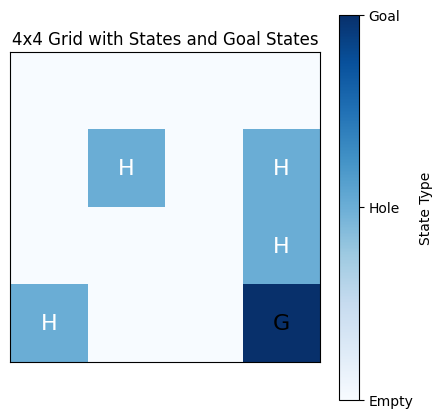

In [59]:
# Define the grid size
grid_size = 4

# Create a grid to visualize states
grid = np.zeros((grid_size, grid_size), dtype=int)

# Identify goal states and update the grid
for state in range(env.observation_space.n):
    row, col = divmod(state, grid_size)
    if env.desc[row, col] == b'G':
        grid[row, col] = 2  # Goal state
    elif env.desc[row, col] == b'H':
        grid[row, col] = 1  # Hole (danger state)
    else:
        grid[row, col] = 0  # Empty space

# Plotting the grid
fig, ax = plt.subplots(figsize=(5, 5))

# Create a colormap for visualization
cmap = plt.get_cmap('Blues')
cmap.set_under('grey')  # Color for holes
cmap.set_over('green')  # Color for goal states

# Show the grid
cax = ax.matshow(grid, cmap=cmap, vmin=0, vmax=2)

# Annotate each cell with state information
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i, j] == 2:
            ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=16)
        elif grid[i, j] == 1:
            ax.text(j, i, 'H', ha='center', va='center', color='white', fontsize=16)
        else:
            ax.text(j, i, '', ha='center', va='center', color='black')

# Set grid properties
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4x4 Grid with States and Goal States')

# Add color bar
cbar = plt.colorbar(cax, ticks=[0, 1, 2])
cbar.set_ticklabels(['Empty', 'Hole', 'Goal'])
cbar.set_label('State Type')

plt.show()

### 3. Define the Q-Learning Algorithm

Implement the Q-learning update rule and train the agent.



In [ ]:
def q_learning(env, Q, alpha, gamma, epsilon, n_episodes, epsilon_decay=0.995, min_epsilon=0.01, max_steps=100):
    # History of rewards and epsilon evolution
    reward_history = []
    epsilon_history = []

    for episode in range(n_episodes):
        # Reset the environment and retrieve the initial state
        state = env.reset()  # env.reset() returns (observation, info) with new_step_api=True
        done = False
        total_reward = 0

        for step in range(max_steps):
            # Epsilon-greedy policy
            if np.random.rand() < epsilon:
                # Exploration: random action
                action = env.action_space.sample()
            else:
                # Exploitation: action with the maximum Q-value
                action = np.argmax(Q[state, :])

            # Perform the action in the environment
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward

            # Update the Q-table
            # Q(s,a) <- Q(s,a) + alpha*[r + gamma*max_a' Q(s',a') - Q(s,a)]
            Q[state, action] = Q[state, action] + alpha * (
                reward + gamma * np.max(Q[next_state, :]) - Q[state, action]
            )

            # Update the current state
            state = next_state

            if done:
                break

        # Reduce epsilon after each episode (decrease the probability of exploration)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        epsilon_history.append(epsilon)
        reward_history.append(total_reward)

        # Display progress every 100 episodes
        if (episode + 1) % 100 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(reward_history, label='Rewards per episode')
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.title('Training Progress')
            plt.legend()
            plt.show()

    # Plot epsilon evolution curve
    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Evolution During Training')
    plt.show()

    return Q


### 4. Train the Agent

Run the training loop to update the Q-table.



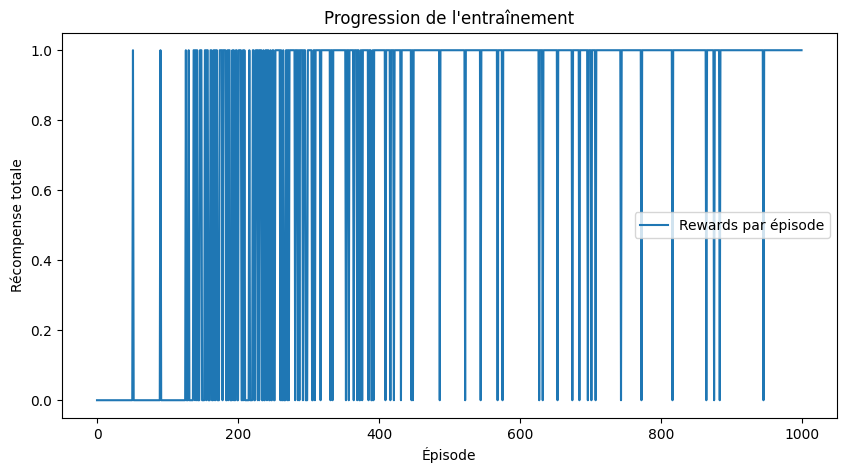

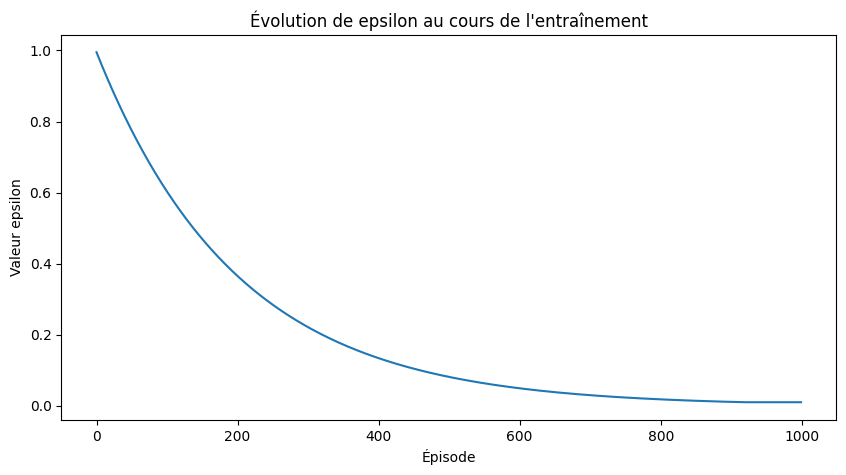

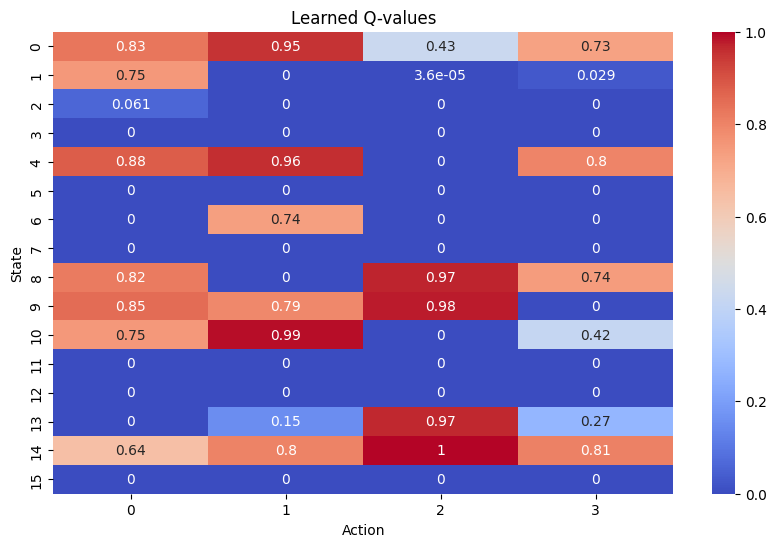

In [61]:
# Train the Q-learning agent
Q = q_learning(env, Q, alpha, gamma, epsilon, n_episodes)

# Save the trained Q-table
np.save('q_table.npy', Q)

# Visualize the learned Q-values
plt.figure(figsize=(10, 6))
sns.heatmap(Q, annot=True, cmap='coolwarm')
plt.title('Learned Q-values')
plt.xlabel('Action')
plt.ylabel('State')
plt.show()


### 5. Evaluate the Learned Policy

Use the trained Q-table to evaluate the learned policy and visualize the results.

In [62]:
# Load the trained Q-table
Q = np.load('q_table.npy')

# Test the learned policy
def test_policy(env, Q):
    state = env.reset()  # En supposant que env.reset() retourne (observation, info) avec le new_step_api=True
    done = False
    total_reward = 0

    while not done:
        # Choisir l'action qui a la plus forte Q-valeur
        action = np.argmax(Q[state])

        # Effectuer l'action
        next_state, reward, done, truncated, info = env.step(action)
        total_reward += reward

        # Mettre à jour l'état
        state = next_state

    return total_reward

# Run the evaluation
total_rewards = [test_policy(env, Q) for _ in range(100)]
average_reward = np.mean(total_rewards)

print(f'Average reward over 100 episodes: {average_reward}')


Average reward over 100 episodes: 1.0


### 6. Plot Q-Values (Optional)

Visualize the Q-values to understand how the agent has learned.



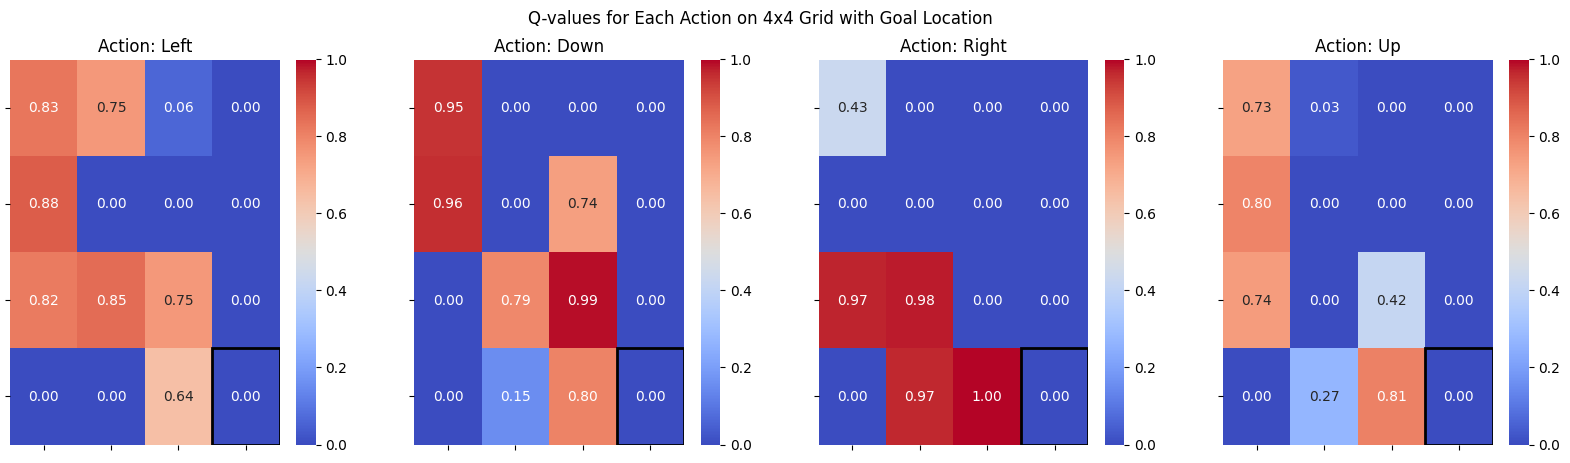

In [63]:
# Reshape Q-values to 4x4 grid
q_values_grid = np.zeros((4, 4, n_actions))

# Get the goal state from the environment
goal_state = 15  # Typically, you can find this from the environment’s specification or documentation

for state in range(n_states):
    row, col = divmod(state, 4)
    q_values_grid[row, col] = Q[state]

# Determine the global min and max for consistent color scale
q_min = np.min(q_values_grid)
q_max = np.max(q_values_grid)

# Define action labels
action_labels = ['Left', 'Down', 'Right', 'Up']

# Get the goal location in the grid
goal_row, goal_col = divmod(goal_state, 4)

# Plot Q-values on the 4x4 grid with consistent color scale
fig, axes = plt.subplots(1, n_actions, figsize=(20, 5), sharex=True, sharey=True)

for action in range(n_actions):
    ax = axes[action]
    sns.heatmap(q_values_grid[:, :, action], annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
                vmin=q_min, vmax=q_max, ax=ax)
    # Highlight the goal state
    ax.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, edgecolor='black', facecolor='none', lw=2))
    ax.set_title(f'Action: {action_labels[action]}')
    ax.set_xticks(np.arange(4) + 0.5)
    ax.set_yticks(np.arange(4) + 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.suptitle('Q-values for Each Action on 4x4 Grid with Goal Location')
plt.show()

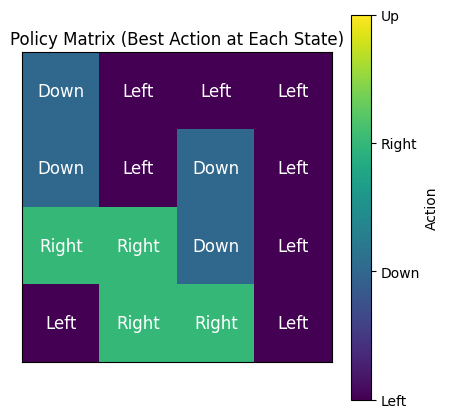

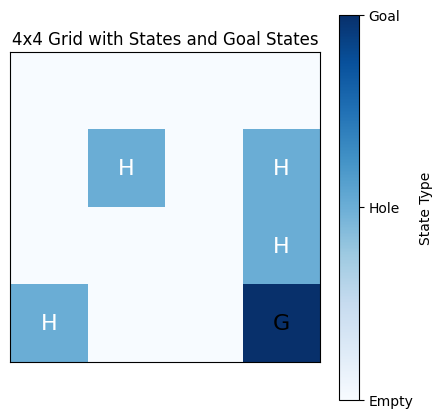

In [64]:
# Define action labels for better understanding
action_labels = ['Left', 'Down', 'Right', 'Up']

# Initialize a matrix to store the best action for each state
policy_matrix = np.zeros((4, 4), dtype=int)

# Determine the best action for each state
for state in range(env.observation_space.n):
    best_action = np.argmax(Q[state])
    row, col = divmod(state, 4)
    policy_matrix[row, col] = best_action

# Create a color map for the actions
action_color_map = {0: 'Left', 1: 'Down', 2: 'Right', 3: 'Up'}

# Plot the policy matrix
fig, ax = plt.subplots(figsize=(5, 5))

# Create a grid
cax = ax.matshow(policy_matrix, cmap='viridis', vmin=0, vmax=n_actions-1)

# Add color bar
cbar = plt.colorbar(cax)
cbar.set_ticks(range(n_actions))
cbar.set_ticklabels([action_labels[i] for i in range(n_actions)])
cbar.set_label('Action')

# Annotate each cell with the action label
for i in range(4):
    for j in range(4):
        ax.text(j, i, action_labels[policy_matrix[i, j]],
                ha='center', va='center',
                color='white', fontsize=12)

# Set grid properties
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Policy Matrix (Best Action at Each State)')

plt.show()


# Plotting the grid
fig, ax = plt.subplots(figsize=(5, 5))

# Create a colormap for visualization
cmap = plt.get_cmap('Blues')
cmap.set_under('grey')  # Color for holes
cmap.set_over('green')  # Color for goal states

# Show the grid
cax = ax.matshow(grid, cmap=cmap, vmin=0, vmax=2)

# Annotate each cell with state information
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i, j] == 2:
            ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=16)
        elif grid[i, j] == 1:
            ax.text(j, i, 'H', ha='center', va='center', color='white', fontsize=16)
        else:
            ax.text(j, i, '', ha='center', va='center', color='black')

# Set grid properties
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4x4 Grid with States and Goal States')

# Add color bar
cbar = plt.colorbar(cax, ticks=[0, 1, 2])
cbar.set_ticklabels(['Empty', 'Hole', 'Goal'])
cbar.set_label('State Type')

plt.show()

## Conclusion

In this lab, you have implemented the Q-learning algorithm and applied it to the FrozenLake environment. You learned how to update Q-values, train an agent, and evaluate the performance of the learned policy.

Feel free to experiment with different hyperparameters and environments to deepen your understanding of Q-learning.